In [78]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines
from lifelines import KaplanMeierFitter, statistics
import numpy as np
import re
import subprocess

In [79]:
# Create a dataframe from data stored on GitHub

df = pd.read_csv('https://github.com/aubreymoore/OrNV-Transmission/raw/master/ornv-transmission.csv', 
                 parse_dates=[3,4])
#print df.info()

In [80]:
# Create some extra columns
# t is time until death in days after start of bioassay
# e is a boolean indication that the beetle died during the bioassay

df['date_end_bioassay'] = df.date_died.max()
t, e = lifelines.utils.datetimes_to_durations(
    start_times=pd.to_datetime(df.date_treated),
    end_times=pd.to_datetime(df.date_died),
    fill_date=pd.to_datetime(df.date_end_bioassay))
df['t'] = t
df['e'] = e
df

,jar_id,sex,treatment,date_treated,date_died,date_end_bioassay,t,e
0,C1,m,none,2019-12-26,2020-01-16,2020-02-06,21.0,True
1,C2,m,none,2019-12-26,2020-01-29,2020-02-06,34.0,True
2,C3,m,none,2019-12-26,2020-01-19,2020-02-06,24.0,True
3,C4,m,none,2019-12-26,2020-01-21,2020-02-06,26.0,True
4,C5,m,none,2019-12-26,2020-01-29,2020-02-06,34.0,True
5,C6,m,none,2019-12-27,NaT,2020-02-06,41.0,False
6,C7,m,none,2019-12-27,2020-01-02,2020-02-06,6.0,True
7,C8,m,none,2019-12-27,2020-01-23,2020-02-06,27.0,True
8,C9,m,none,2019-12-27,2020-01-25,2020-02-06,29.0,True
9,C10,m,none,2019-12-27,NaT,2020-02-06,41.0,False


<IPython.core.display.Javascript object>


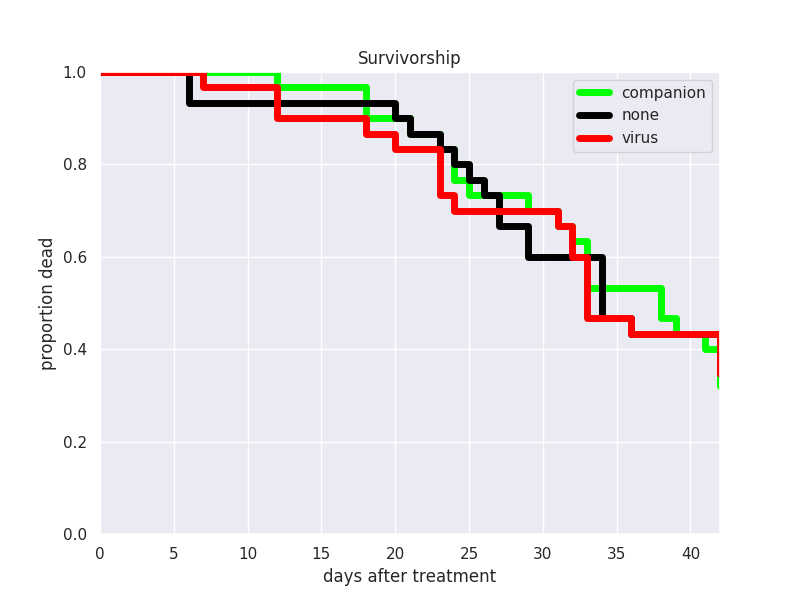

In [81]:
# Generate a survivorship plot.

sns.set()

# Create custom palette
colors = ["#00FF00", "#000000","#FF0000", ]
sns.set_palette(sns.color_palette(colors))

# Create survorship plot

fig, ax = plt.subplots(figsize=(8,6))
kmf = KaplanMeierFitter()
for name, grouped_df in df.groupby('treatment'):
    kmf.fit(grouped_df['t'], grouped_df['e'], label=name)
    kmf.plot(ax=ax, linewidth=5, ci_show=False)
ax.set_xlabel('days after treatment')
ax.set_ylabel('proportion dead')
ax.set_ylim([0,1])
ax.set_title('Survivorship');
fig.savefig('survivorship.pdf')

In [82]:
def plot_pairs(tgroup, plot_title):
    """
    Generate a plot showing dates on which partneres were found dead.
    
    tgroup: 'TF' or 'TM'
    plot_title: 'Females dosed with virus' for example
    """
    # Copy the slice where jar_id starts with 'TF'
    dftf = df[df.jar_id.str.startswith(tgroup)].copy()

    # Filter out beetles which did not die
    dftf = dftf[dftf.e]

    # Create 'pair_id' column
    dftf['pair_id'] = dftf.apply(lambda row: int(re.findall('\d+',row.jar_id)[0]), axis=1)

    # Sort so that virus treatments come first
    dftf.sort_values(by='treatment', inplace=True, ascending=False)

    sns.set()

    # Create custom palette
    colors = ["#FF0000", "#00FF00"]
    sns.set_palette(sns.color_palette(colors))

    p = sns.lmplot(x='t', y='pair_id', data=dftf, hue='treatment', fit_reg=False, y_jitter=0.2)
    p = p.set(xlim=(0,42))
    p = p.set(ylim=(0,16))
    p = p.set(yticks=np.arange(1,16,1))
    p = p.set(xticks=np.arange(0,42,4))
    plt.title(plot_title)
    return p

#p = plot_pairs('TF', 'Females dosed with virus')
#p.savefig('tf.pdf')

<IPython.core.display.Javascript object>


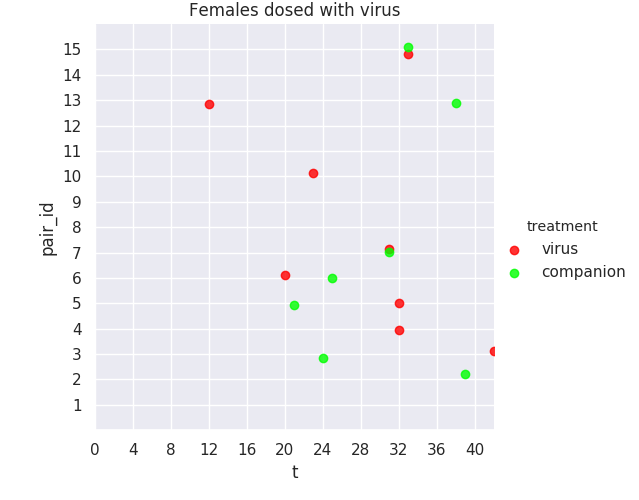

In [83]:


p = plot_pairs('TF', 'Females dosed with virus')
p.savefig('tf.pdf')

<IPython.core.display.Javascript object>


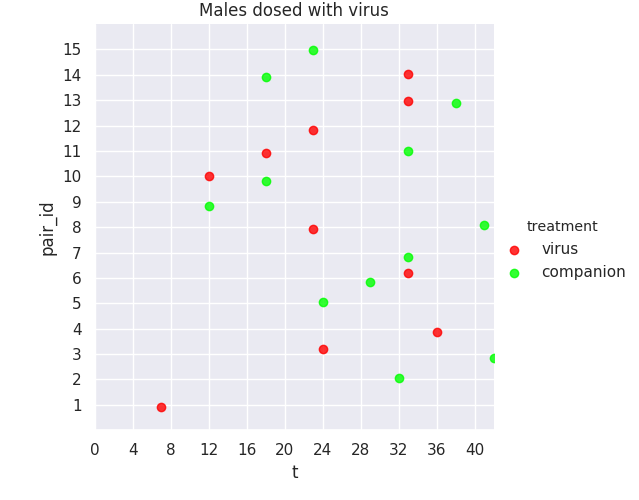

In [84]:
p = plot_pairs('TM', 'Males dosed with virus')
p.savefig('tm.pdf')

In [85]:
s = r"""

\documentclass[11pt,letterpaper]{scrartcl}
\usepackage{graphicx}
\usepackage{booktabs}

\begin{document}

\title{OrNV Transmission Experiment}
\author{James Grasela and Aubrey Moore}
\maketitle

\begin{abstract}
This experiment was performed to determine if OrNV isolate V23B can be transmitted from a dosed CRB adult to an undosed CRB 
adult.
\end{abstract}

\section{Materials and Methods}

\subsection{Beetles}

\subsection{Virus}

Beetles were dosed per os with ca. 30 μl V23B virus preparation of unknown concentration (AgResearch, New Zealand).

\subsection{Experimental design}

To test for virus transmission, beetles were selected at random and assigned to 45 pairs with a male and a female 
in each pair. These pairs were housed in Mason jars half filled with moist peat moss. The jars were held under 
standard rearing conditions in an environmental chamber: 30 deg C; 80\% RH; 12h photoperiod. At the start of the 
bioassay, the beetle pairs were randomly placed in 3 treatment groups of 15 jars each. 

\begin{table}[h]
	\centering
\caption{caption}
	
\begin{tabular}{ll}
	\toprule
	Treatment group & Treatment\\
	\midrule
	Jars labeled C1 through C15 & Experimental control; neither beetle was dosed\\
    Jars labeled TF1 through TF15 & Female was dosed with virus; male was not dosed\\
    Jars labeled MF1 through MF15 & Female was dosed with virus; male was not dosed\\
	\bottomrule
\end{tabular} 

\end{table}

\section{Results}

\begin{figure}[h]
\centering
\includegraphics[width=\textwidth]{survivorship.pdf}
\caption{Caption}
\label{fig:survivorship}
\end{figure}

\begin{figure}[h]
\centering
\includegraphics[width=\textwidth]{tf.pdf}
\caption{Caption}
\label{fig:tf}
\end{figure}

\begin{figure}[h]
\centering
\includegraphics[width=\textwidth]{tm.pdf}
\caption{Caption}
\label{fig:tf}
\end{figure}

\section{BibTex}

\end{document}

"""

with open('ornv-transmission.tex', 'w') as f: 
    f.write(s) 

In [87]:
subprocess.call(['pdflatex', 'ornv-transmission.tex'])

0

In [89]:
subprocess.call(['xdg-open', 'ornv-transmission.pdf'])

0